In [120]:
import numpy as np
from matplotlib import pyplot as plt
from time import time
plt.rcParams["figure.dpi"] = 300
π = np.pi

## Recreate Important Tools

In [121]:
class Channel(object) :
    '''
    Creates a Channel object to simulate a wiretap channel over (air communications?).
    Similar to Simulink's 256 QAM channel modulating tool
    
    '''
    def __init__(self,dom='C') :
        '''
        '''
        self.SNR = 6
        self.type = dom
        self.snd_sig = None
        self.rec_sig = None
    
    def generate_sig(self,n=1.05e4,QAM=256) :
        '''
        Generates an aribitrary signal of length n to send, with values from 0 to QAM.
        
        Note: If the passed value of n is a float, then this function rounds it down to
        the nearest int.
        '''
        if not isinstance(n,(int,float)) :
            raise TypeError('n must be an integer.')
        n = int(n)
        self.snd_sig = np.random.randint(0,high=QAM,size=n)
    
    def awgn(self,sig) :
        '''
        Adds white gaussian noise (complex) to a signal

        Input :
            sig   - (n,) array - The signal

        Output :
            n_sig - (n,) array - The noisy signal
        '''
        if not isinstance(sig,(list,np.ndarray)) :
            raise TypeError('Signal must be a list or ndarray.')
        sig = np.array(sig)
        if len(sig.shape) != 1 :
            raise ValueError('Signal must be one dimensional.')
        N = sig.shape[0]
        if self.type == 'C' :
            noise = np.random.multivariate_normal(np.array([0,0]),np.eye(2),N)
            n_sig = [sig[i]+(noise[i][0]+noise[i][1]*1j)/self.SNR for i in range(N)]
        else :
            n_sig = sig + np.random.normal(0,1,size=sig.shape)/self.SNR
        return n_sig
    
    def send_sig(self,new_sig=None) :
        '''
        Simulates sending the generated signal over this channel.
        '''
        if new_sig :
            self.snd_sig = new_sig
        elif self.snd_sig is None :
            self.generate_sig()
        # Add white noise
        rec = self.awgn(self.snd_sig)
        self.rec_sig = self.err_corr(rec)
        self.ber, self.num_err, self.num_bits = self.biterr()
        return self

    def biterr(self,rec_sig=None) :
        '''
        Calculates the biterror rate of the channel.
        Note: This calculation doesn't allow for bit deletions or insertions.
        
        Input :
            rec_sig    - (n,) array - The received signal
        
        Output :
            be         - The bit error rate
            num_errors - The total number of error bits
            n1         - The total number of bits in the signal
        '''
        if rec_sig is not None and not isinstance(rec_sig,np.ndarray) :
            raise TypeError('Rec_sig must be ndarrays.')
        elif rec_sig == None :
            rec_sig = self.rec_sig
        n1,n2 = self.snd_sig.shape[0],rec_sig.shape[0]
        if n1 != n2 :
            raise ValueError('Both signals must have the same shape.')
        num_errors = np.count_nonzero(self.snd_sig-rec_sig)
        be = num_errors/n1
        return be, num_errors, n1
    
    def err_corr(self,rec_sig=None) :
        '''
        Takes the received signal and calculates the most likely signal sent by 
        '''
        if rec_sig is None :
            rec_sig = self.rec_sig
        fin_sig = np.array([round(symbol).real for symbol in rec_sig])
        return fin_sig

def plot_ber(channel,signal_beam,noise_beams) :
    '''
    Plots the estimated bit error rate for certain locations base on SNR
    
    Input :
        channel - (Channel) - The channel in use
        signal_beam - (n,) array - The strength of the signal at each angle
        noise_beams - list - List of noise beams like signal beam
    '''
    θ = np.linspace(0,π,len(signal_beam))
    r = np.linspace(0,50,len(signal_beam))
    R,Θ = np.meshgrid(r,θ)
    channel.generate_sig()
    channel.rec_sig = None
    Z1 = np.zeros_like(Θ)
    Z2 = np.zeros_like(Θ)
    for j in range(len(θ)) :
        for i in range(len(r)) :
            sig_pow = 0
            noise_pow = 6 # Standard(?) white noise value
            # Get 'signal' and 'noise' values from beams
            if signal_beam[j] >= r[j] :
                sig_pow = signal_beam[j]
            for beam in noise_beams :
                if beam[j] >= r[i] :
                    noise_pow += beam[j]
            # Set SNR for specific position
            channel.SNR = sig_pow/noise_pow
            Z2[i,j] = channel.SNR
            channel.send_sig()
            Z1[i,j] = channel.ber
        if (j+1) % 100 == 0 :
            print(f'{j+1}th iteration complete.')
    return Z1,Z2

def f(func,C) :
    '''
    If C = UΣU.T, then f(C) = Uf(Σ)U.T = U*diag(func(σ_1),...,func(σ_2))*U.T
    
    Inputs :
        func - Callable scalar function
        C    - Cross Spectral Matrix of a system
        
    Output :
        f(C) as defined in description
    '''
    eigv, U = np.linalg.eig(C)
    f_eigs = [func(eig) for eig in eigv]
    return U@np.diag(f_eigs)@U.T

def calc_coeffs(θ,N,r,λ) :
    '''
    Calculates the coefficients of the beam equation
    
    Inputs:
        θ (rad) - angle off from orthogonal to array
        N (int) - number of antenna +1
    
    Output:
        a_k for the beam form equation Σ_1^N <a_k(θ), x_k> where x_k is the volatge response of antenna k
        NOTE: This vector is normalized (why? I don't know)
    '''
    ϕ = -π*np.sin(θ) # Why is this negative?
    bs = np.zeros(N).astype(complex)
    for k in range(N) :
        bs[k] = np.exp(ϕ*k*1j)
    return bs/np.linalg.norm(bs)

In [122]:
chn = Channel()
chn.send_sig()
print(chn.ber,chn.num_err,chn.num_bits)

0.003142857142857143 33 10500


In [123]:
chn = Channel(dom='R')
chn.send_sig()
print(chn.ber,chn.num_err,chn.num_bits)

0.0030476190476190477 32 10500


In [126]:
N = 7                            # Number of antenna
λ = 1                            # Wavelength
num_points = 300
beam_θ = 5*π/7                     # Desired azmith angle
θs = np.linspace(0,π,num_points)
ak = calc_coeffs(beam_θ,N,100,λ)
s_k = 50                         # Alice's signal strength
g_k = np.array(ak).reshape(1,N)  # Direction of Alice's transmitter relative to Bob (in this case, beam_θ)
b = lambda g,n=1 : s_k*(float(g_k@g))**(2*n)
C = s_k*(np.dot(g_k.T,g_k))      # Cross Spectral Matrix
noise_beam = [b(calc_coeffs(θ,N,s_k,λ)) for θ in θs]
sig_beam = [b(calc_coeffs(θ,N,s_k,λ),3) for θ in θs]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:162: ComplexWarning: Casting complex values to real discards the imaginary part


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


100th iteration complete.
200th iteration complete.
300th iteration complete.
400th iteration complete.
500th iteration complete.


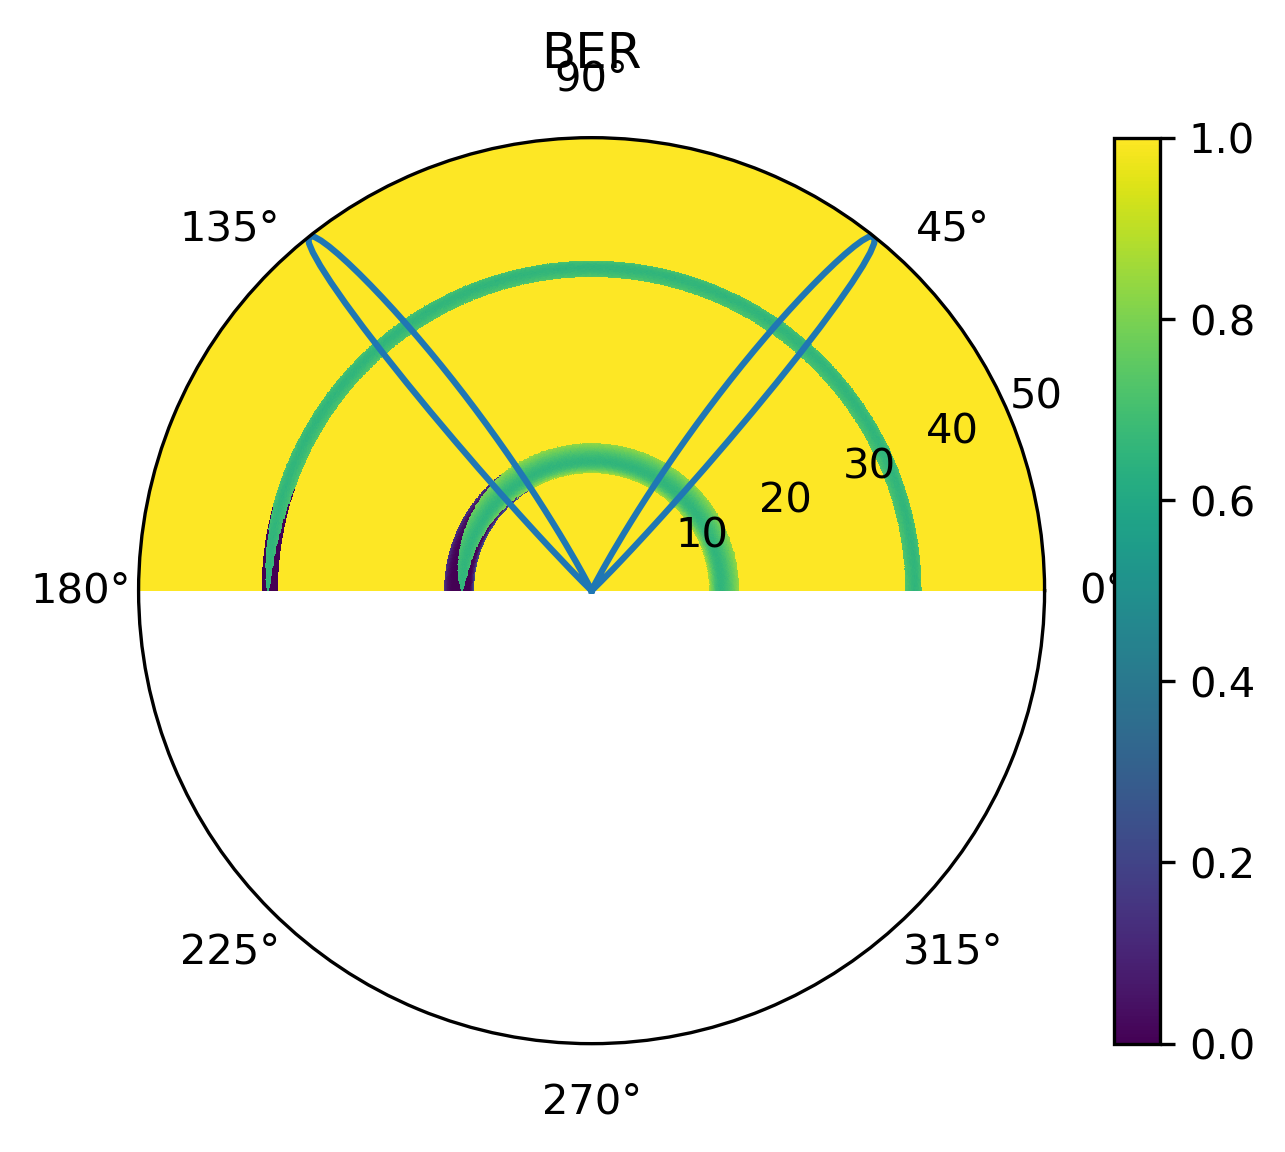

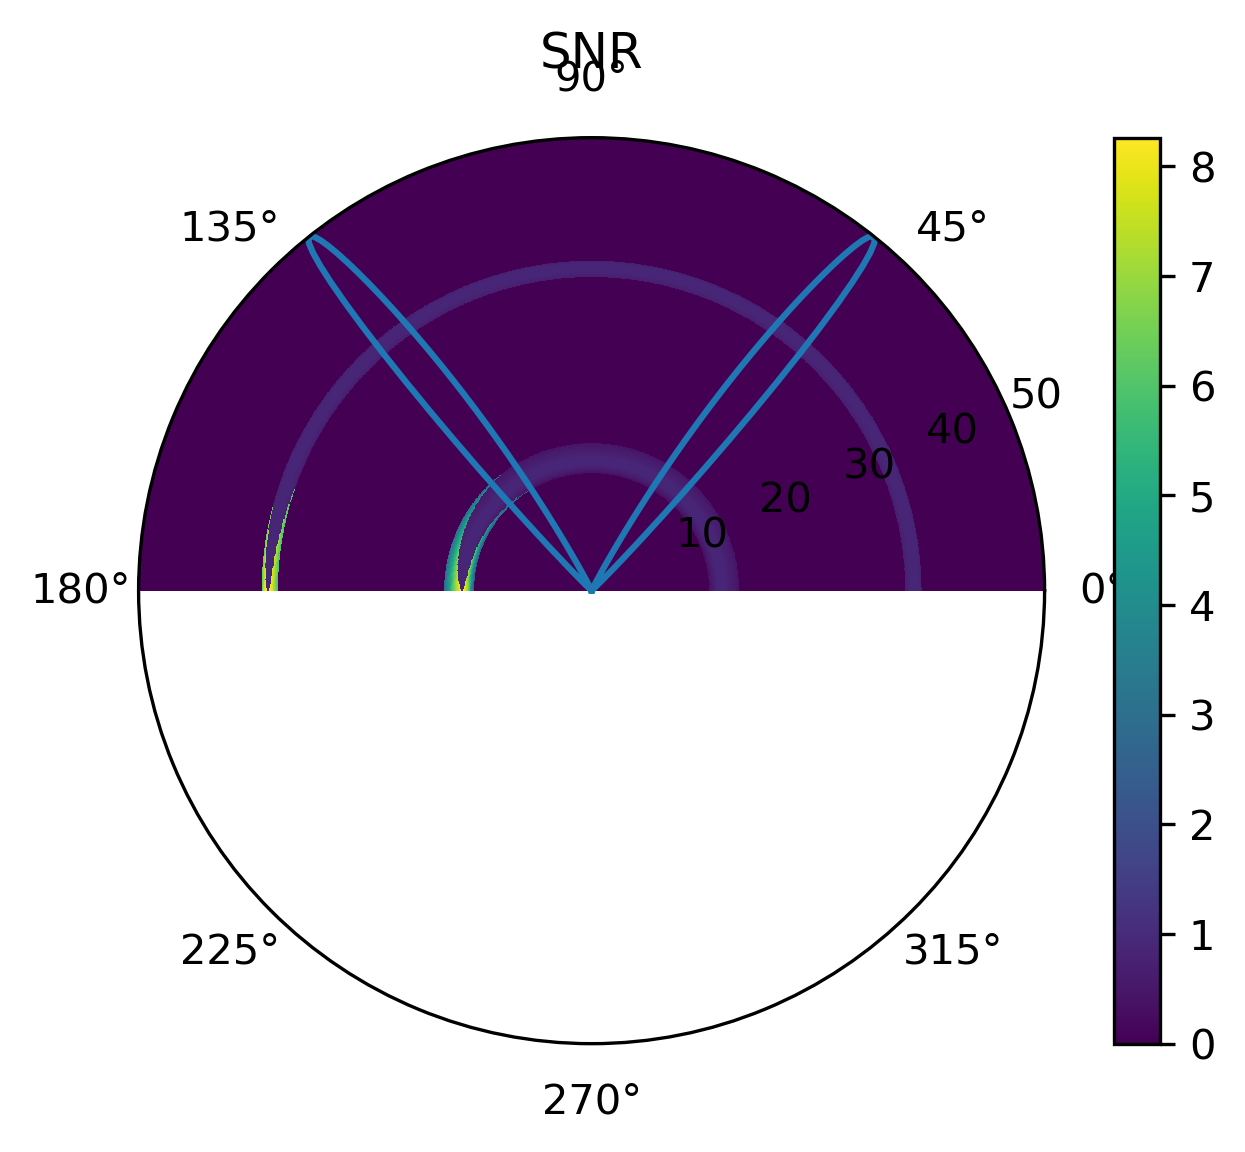

In [127]:
start = time()
Z1,Z2 = plot_ber(chn,sig_beam,[noise_beam])
end = time()
print(f'Took {end-start}.')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


100th iteration complete.
200th iteration complete.
300th iteration complete.
Took 949.7763409614563.


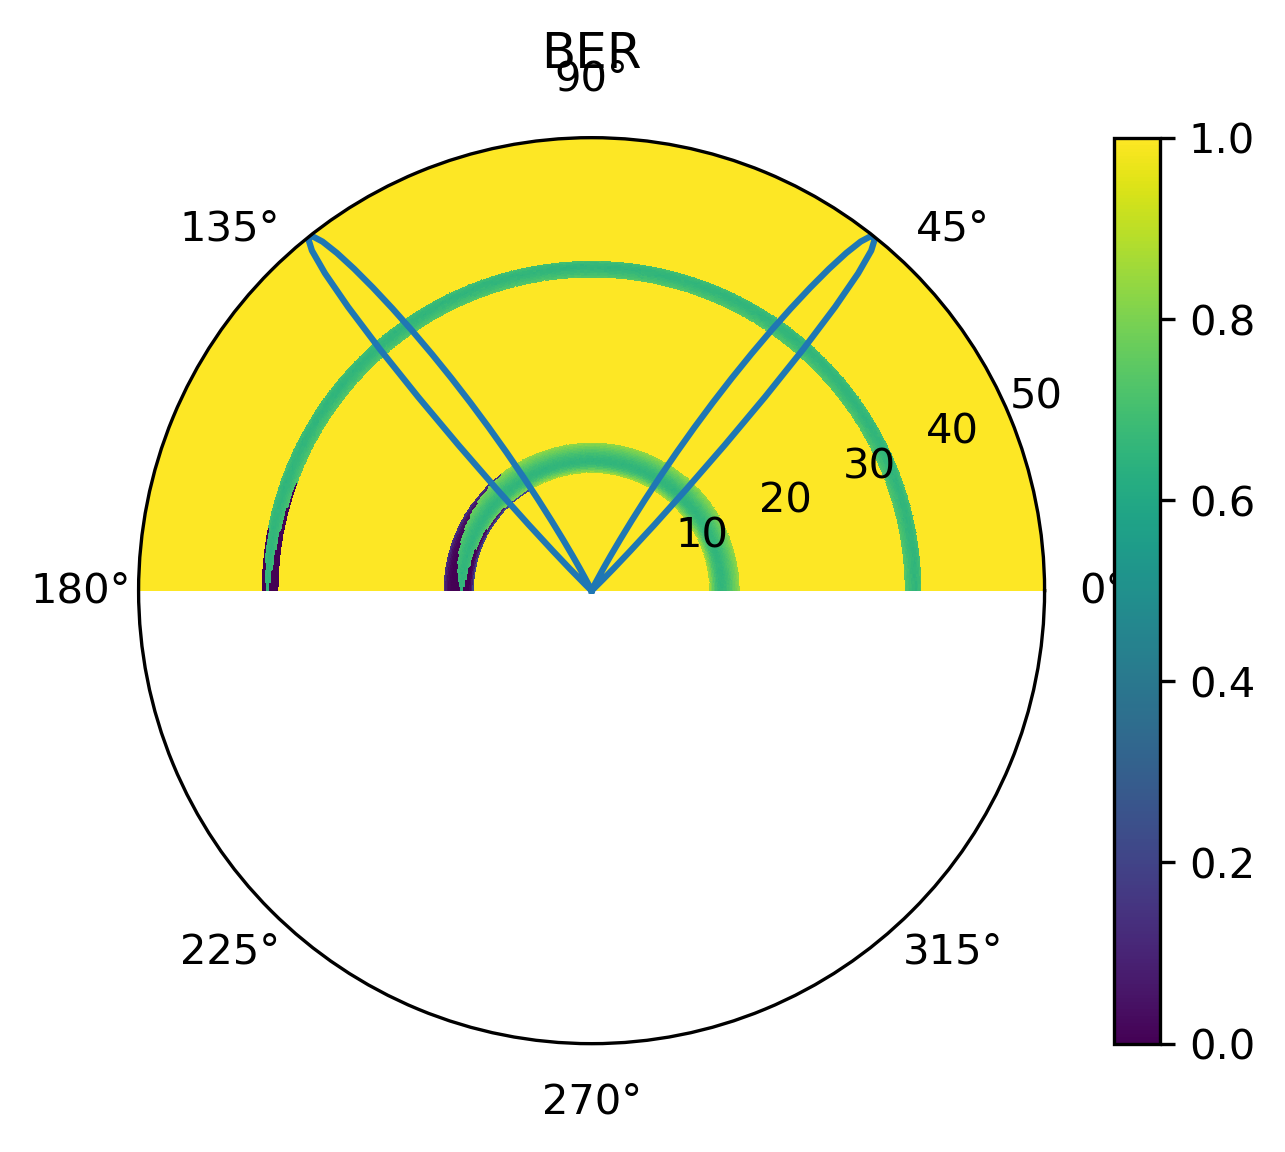

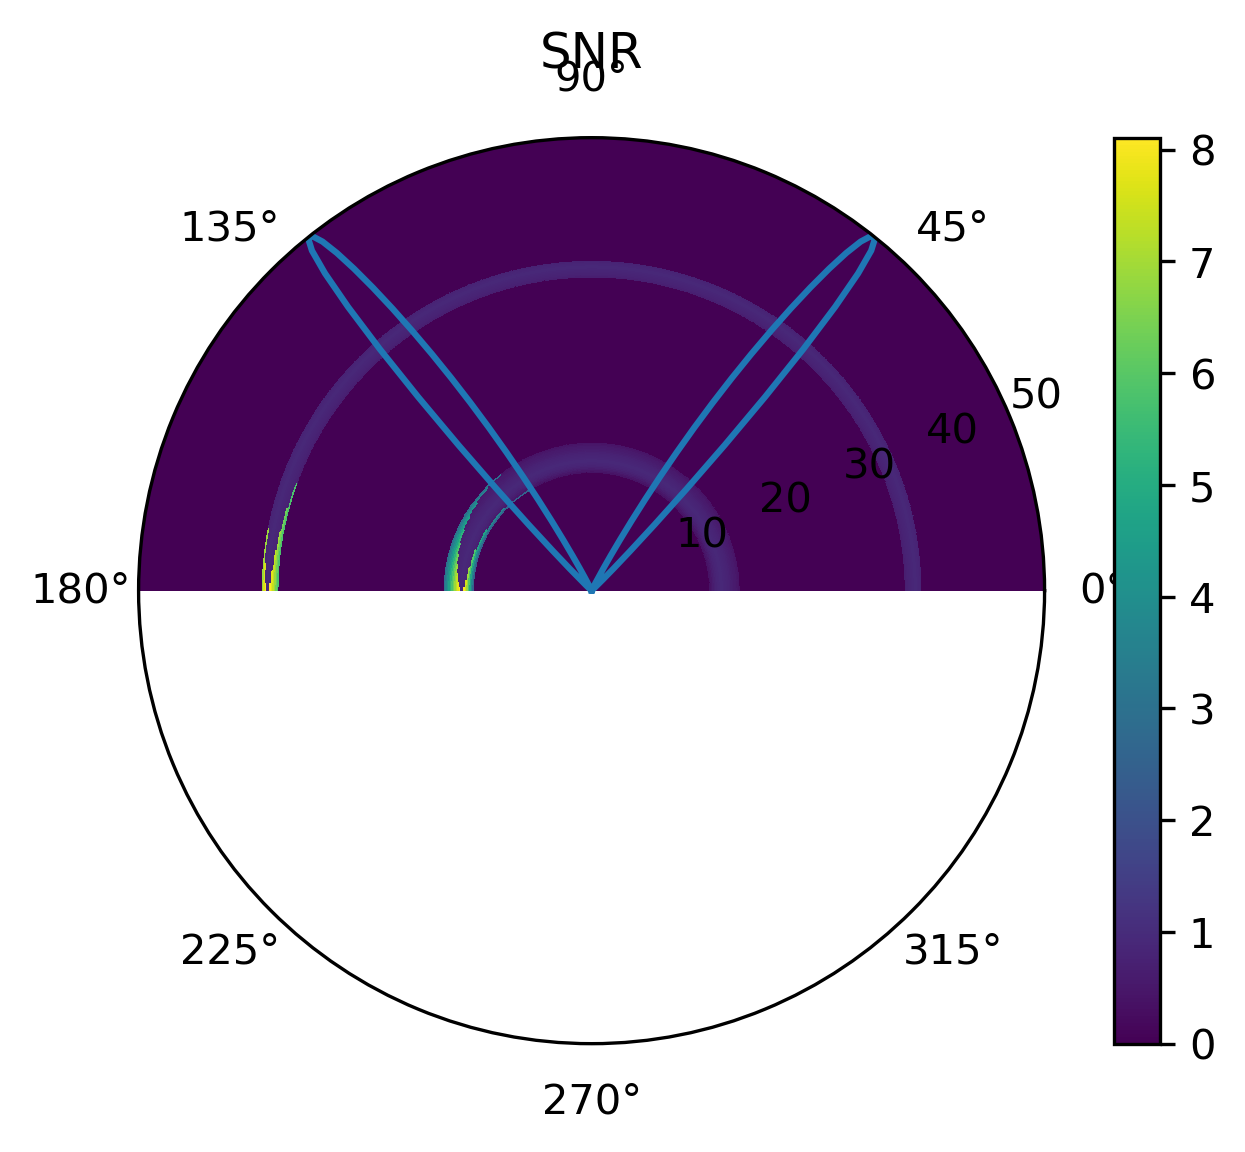

In [130]:
θ = np.linspace(0,π,num_points)
r = np.linspace(0,50,num_points)
R,Θ = np.meshgrid(r,θ)
plt.polar(θ,sig_beam)
plt.pcolor(Θ,R,Z1)
plt.colorbar()
plt.title('BER')
plt.show()
plt.polar(θ,sig_beam)
plt.pcolor(Θ,R,Z2)
plt.title('SNR')
plt.colorbar()
plt.show()

In [ ]:
# See http://scipy-cookbook.readthedocs.io/items/CommTheory.html

#!/usr/bin/python
# BPSK digital modulation: modified example
# by Ivo Maljevic

from scipy import *
from math import sqrt, ceil  # scalar calls are faster
from scipy.special import erfc
import matplotlib.pyplot as plt

rand   = random.rand
normal = random.normal

SNR_MIN   = 0
SNR_MAX   = 10
FrameSize = 10000
Eb_No_dB  = arange(SNR_MIN,SNR_MAX+1)
Eb_No_lin = 10**(Eb_No_dB/10.0)  # linear SNR

# Allocate memory
Pe        = empty(shape(Eb_No_lin))
BER       = empty(shape(Eb_No_lin))

# signal vector (for faster exec we can repeat the same frame)
s = 2*random.randint(0,high=2,size=FrameSize)-1

loop = 0
for snr in Eb_No_lin:
    No        = 1.0/snr
    Pe[loop]  = 0.5*erfc(sqrt(snr))
    nFrames   = ceil(100.0/FrameSize/Pe[loop])
    error_sum = 0
    scale = sqrt(No/2)

    for frame in arange(nFrames):
        # noise
        n = normal(scale=scale, size=FrameSize)

        # received signal + noise
        x = s + n

        # detection (information is encoded in signal phase)
        y = sign(x)

        # error counting
        err = where (y != s)
        error_sum += len(err[0])

        # end of frame loop
        ##################################################

    BER[loop] = error_sum/(FrameSize*nFrames)  # SNR loop level
    print 'Eb_No_dB=%2d, BER=%10.4e, Pe[loop]=%10.4e' % \
        (Eb_No_dB[loop], BER[loop], Pe[loop])
    loop += 1

plt.semilogy(Eb_No_dB, Pe,'r',linewidth=2)
plt.semilogy(Eb_No_dB, BER,'-s')
plt.grid(True)
plt.legend(('analytical','simulation'))
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.show()